# 03a - Differential Abundance Analysis

## I. Preliminaries

Import the libraries and functions for model evaluation.

In [76]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import os
import torch
import yaml
import pickle


from metaboDGD.analysis import daa
from metaboDGD.src.dataset import MetaboliteDataset
from metaboDGD.src import model
from metaboDGD.src.latent import RepresentationLayer

In [77]:
metabolite_list = []

f = open('metabolite_list.txt', 'r')
for i in f:
    if i.strip('\n') != 'cohort':
        metabolite_list.append(i.strip('\n'))
f.close()

In [78]:
normal_sample_list = []

f = open('normal_sample_list.txt', 'r')
for i in f:
    normal_sample_list.append(i)
f.close()

In [79]:
disease_sample_list = []
f = open('disease_sample_list.txt', 'r')
for i in f:
    disease_sample_list.append(i)
f.close()

In [80]:
f = open('outputs/results.pkl', 'rb')
results = pickle.load(f)
f.close()

np_normal_lbls = results['np_normal_lbls']
np_normal_log = results['np_normal_log']
cohorts_normal = results['cohorts_normal']

np_tumor_lbls = results['np_tumor_lbls']
np_tumor_log = results['np_tumor_log']
cohorts_tumor = results['cohorts_tumor']

In [81]:
config_model = yaml.safe_load(open('model.yaml', 'r'))
config_train = yaml.safe_load(open('train.yaml', 'r'))

dgd_final = model.MetaboDGD(**config_model)
dgd_final.dec.load_state_dict(torch.load('torch_outputs/torch_outputs_dec.pt'))
dgd_final.gmm.load_state_dict(torch.load('torch_outputs/torch_outputs_gmm.pt'))

train_rep_final = RepresentationLayer(values=torch.zeros(size=(np_normal_log.shape[0], dgd_final.gmm.dim)))
train_rep_final.load_state_dict(torch.load('torch_outputs/torch_outputs_train_rep.pt'))

<All keys matched successfully>

In [82]:
f = open('outputs/tumor_results.pkl', 'rb')
tumor_results = pickle.load(f)
f.close()

tumor_rep_final = tumor_results['tumor_rep_final']
dec_out_final   = tumor_results['dec_out_final']

## II. SPECIFICITY
Real Normal vs. Real/Generated Normal

### **RN vs. GN** (Many vs. Many via MWU) and **RN vs. RN** (Many vs. Many via MWU)

In [ ]:
idx_camp_normal = [
    (np.r_[0:47], 'BRCA1'),
    (np.r_[47:94], 'CCRCC3'),
    (np.r_[118:157],'COAD'),
    (np.r_[178:224], 'PRAD')
]
n_samples = 15
config_opt = yaml.safe_load(open('opt.yaml', 'r'))
# threshold = np.arange(0.01, 0.11, 0.01)

dam_results = {}

for idxs, cohort in idx_camp_normal:
    dam_results[cohort] = {
        'mwu_rngn_results': [],
        'mwu_rnrn_results': [],
    }

    for i in range(0, 30):
        # Set randomizer seed
        gen = np.random.default_rng(i)

        # Reset the index of each cohort's index
        idx_filtered = np.r_[0:len(idxs)]
        
        # Get the original cohort indices
        normal_camp = np_normal_log[idxs,:]
        normal_camp_lbls = np_normal_lbls[idxs]

        # Get indices from one group
        rn_idx_grp_01 = gen.choice(idx_filtered,size=n_samples, replace=False)
        rn_other_idx = np.array(list(set(idx_filtered) - set(rn_idx_grp_01)))

        # Get indices from the remaining group
        rn_idx_grp_02 = gen.choice(rn_other_idx,size=n_samples, replace=False)

        rn_grp_01 = normal_camp[rn_idx_grp_01]
        rn_grp_01_lbls = normal_camp_lbls[rn_idx_grp_01]
        rn_grp_02 = normal_camp[rn_idx_grp_02]
        rn_grp_02_lbls = normal_camp_lbls[rn_idx_grp_02]

        cohort_metabolite_list = cohorts_normal[cohort]['met_list']
        np_metabolite_list = np.array(metabolite_list)
        np_cohort_metabolite_list = np.array(cohort_metabolite_list)
        idx_cohort_metabolite_list = np.nonzero(np.isin(np_metabolite_list, np_cohort_metabolite_list))[0]


        # [GN] Initialize the dataset
        normal_ds = MetaboliteDataset(
            np_mat=rn_grp_01,
            cohort_labels=rn_grp_01_lbls
        )

        # [GN] Get the representations and decoder outputs from the model
        rep_normal, dec_normal = dgd_final.get_representations(normal_ds, config_opt)
        gn_grp = dec_normal.detach().numpy()
        

        # [RN VS GN]
        df_rngn = daa.get_daa_mwu_metrics(rn_grp_01, gn_grp, metabolite_list)
        df_rngn = df_rngn.iloc[idx_cohort_metabolite_list]


        # [RN VS RN]
        df_rnrn = daa.get_daa_mwu_metrics(rn_grp_01, rn_grp_02, metabolite_list)
        df_rnrn = df_rnrn.iloc[idx_cohort_metabolite_list]


        # Save results
        dam_results[cohort]['mwu_rngn_results'].append(len(df_rngn.loc[(df_rngn['q_value'] < 0.05) & (df_rngn['log2_fold_change'] > 1)]))
        dam_results[cohort]['mwu_rnrn_results'].append(len(df_rnrn.loc[(df_rnrn['q_value'] < 0.05) & (df_rnrn['log2_fold_change'] > 1)]))


f = open('outputs/dam_specificity_results.pkl', 'wb')
pickle.dump(dam_results, f)
f.close()

SPECIAL CASE - DIFFERENT p-VALUE THRESHOLDS

In [135]:
idx_camp_normal = [
    (np.r_[0:47], 'BRCA1'),
    (np.r_[47:94], 'CCRCC3'),
    (np.r_[118:157],'COAD'),
    (np.r_[178:224], 'PRAD')
]
n_samples = 15
config_opt = yaml.safe_load(open('opt.yaml', 'r'))
threshold = np.array([0.001, 0.005, 0.01, 0.05, 0.1])

dam_results = {}
threshold_str = [str(np.round(t,3)) for t in threshold]
for idxs, cohort in idx_camp_normal:
    dam_results[cohort] = {}
    for t in threshold_str:
        dam_results[cohort][t] = {
            'mwu_rngn_results': [],
            'mwu_rnrn_results': [],
        }

for idxs, cohort in idx_camp_normal:
    cohort_metabolite_list = cohorts_normal[cohort]['met_list']
    np_metabolite_list = np.array(metabolite_list)
    np_cohort_metabolite_list = np.array(cohort_metabolite_list)
    idx_cohort_metabolite_list = np.nonzero(np.isin(np_metabolite_list, np_cohort_metabolite_list))[0]


    for i in range(0, 30):
        # Set randomizer seed
        gen = np.random.default_rng(i)

        # Reset the index of each cohort's index
        idx_filtered = np.r_[0:len(idxs)]
        
        # Get the original cohort indices
        normal_camp = np_normal_log[idxs,:]
        normal_camp_lbls = np_normal_lbls[idxs]

        # Get indices from one group
        rn_idx_grp_01 = gen.choice(idx_filtered,size=n_samples, replace=False)
        rn_other_idx = np.array(list(set(idx_filtered) - set(rn_idx_grp_01)))

        # Get indices from the remaining group
        rn_idx_grp_02 = gen.choice(rn_other_idx,size=n_samples, replace=False)

        rn_grp_01 = normal_camp[rn_idx_grp_01]
        rn_grp_01_lbls = normal_camp_lbls[rn_idx_grp_01]
        rn_grp_02 = normal_camp[rn_idx_grp_02]
        rn_grp_02_lbls = normal_camp_lbls[rn_idx_grp_02]

        # [GN] Initialize the dataset
        normal_ds = MetaboliteDataset(
            np_mat=rn_grp_01,
            cohort_labels=rn_grp_01_lbls
        )

        # [GN] Get the representations and decoder outputs from the model
        rep_normal, dec_normal = dgd_final.get_representations(normal_ds, config_opt)
        gn_grp = dec_normal.detach().numpy()
        

        # [RN VS GN]
        df_rngn = daa.get_daa_mwu_metrics(rn_grp_01, gn_grp, metabolite_list)
        df_rngn = df_rngn.iloc[idx_cohort_metabolite_list]


        # [RN VS RN]
        df_rnrn = daa.get_daa_mwu_metrics(rn_grp_01, rn_grp_02, metabolite_list)
        df_rnrn = df_rnrn.iloc[idx_cohort_metabolite_list]


        # Save results
        for t, p_val in zip(threshold, dam_results['BRCA1'].keys()):
            dam_results[cohort][p_val]['mwu_rngn_results'].append(len(df_rngn.loc[(df_rngn['q_value'] < t) & (df_rngn['log2_fold_change'] > 1)]))
            dam_results[cohort][p_val]['mwu_rnrn_results'].append(len(df_rnrn.loc[(df_rnrn['q_value'] < t) & (df_rnrn['log2_fold_change'] > 1)]))


f = open('outputs/dam_specificity_results_thresholds_5.pkl', 'wb')
pickle.dump(dam_results, f)
f.close()

### RN vs. GN and RN vs. RN (Other Biospecimens)

In [84]:
idx_camp_normal = [
    (np.r_[224:244], 'feces_MTBLS6334'),
    (np.r_[257:307], 'plasma_MTBLS11094'),
    (np.r_[654:754],'saliva_MTBLS4569'),
    (np.r_[922:1012],'serum_MTBLS2615')
]
n_samples = 10
dam_results_mtbls = {}

for idxs, cohort in idx_camp_normal:
    dam_results_mtbls[cohort] = {
        'mwu_rngn_results': [],
        'mwu_rnrn_results': [],
    }

    for i in range(0, 30):
        # Set randomizer seed
        gen = np.random.default_rng(i)

        # Reset the index of each cohort's index
        idx_filtered = np.r_[0:len(idxs)]
        
        # Get the original cohort indices
        normal_camp = np_normal_log[idxs,:]
        normal_camp_lbls = np_normal_lbls[idxs]

        # Get indices from one group
        rn_idx_grp_01 = gen.choice(idx_filtered,size=n_samples, replace=False)
        rn_other_idx = np.array(list(set(idx_filtered) - set(rn_idx_grp_01)))

        # Get indices from the remaining group
        rn_idx_grp_02 = gen.choice(rn_other_idx,size=n_samples, replace=False)

        rn_grp_01 = normal_camp[rn_idx_grp_01]
        rn_grp_01_lbls = normal_camp_lbls[rn_idx_grp_01]
        rn_grp_02 = normal_camp[rn_idx_grp_02]
        rn_grp_02_lbls = normal_camp_lbls[rn_idx_grp_02]

        cohort_metabolite_list = cohorts_normal[cohort]['met_list']
        np_metabolite_list = np.array(metabolite_list)
        np_cohort_metabolite_list = np.array(cohort_metabolite_list)
        idx_cohort_metabolite_list = np.nonzero(np.isin(np_metabolite_list, np_cohort_metabolite_list))[0]

        # [GN] Initialize the dataset
        normal_ds = MetaboliteDataset(
            np_mat=rn_grp_01,
            cohort_labels=rn_grp_01_lbls
        )

        # [GN] Get the representations and decoder outputs from the model
        rep_normal, dec_normal = dgd_final.get_representations(normal_ds, config_opt)
        gn_grp = dec_normal.detach().numpy()
        

        # [RN VS GN]
        df_rngn = daa.get_daa_mwu_metrics(rn_grp_01, gn_grp, metabolite_list)
        df_rngn = df_rngn.iloc[idx_cohort_metabolite_list]


        # [RN VS RN]
        df_rnrn = daa.get_daa_mwu_metrics(rn_grp_01, rn_grp_02, metabolite_list)
        df_rnrn = df_rnrn.iloc[idx_cohort_metabolite_list]


        # Save results
        dam_results_mtbls[cohort]['mwu_rngn_results'].append(len(df_rngn.loc[(df_rngn['q_value'] < 0.05) & (df_rngn['log2_fold_change'] > 1)]))
        dam_results_mtbls[cohort]['mwu_rnrn_results'].append(len(df_rnrn.loc[(df_rnrn['q_value'] < 0.05) & (df_rnrn['log2_fold_change'] > 1)]))
        # dam_results_mtbls[cohort] = {
        #     'mwu_rngn_results': len(df_rngn.loc[(df_rngn['p_value'] < 0.05) & (df_rngn['log2_fold_change'] > 1)]),
        #     'mwu_rnrn_results': len(df_rnrn.loc[(df_rnrn['p_value'] < 0.05) & (df_rnrn['log2_fold_change'] > 1)]),
        # }


f = open('outputs/dam_mtbls_specificity_results.pkl', 'wb')
pickle.dump(dam_results_mtbls, f)
f.close()

MTBLS - SPECIAL CASE

In [ ]:
idx_camp_normal = [
    (np.r_[224:244], 'feces_MTBLS6334'),
    (np.r_[257:307], 'plasma_MTBLS11094'),
    (np.r_[654:754],'saliva_MTBLS4569'),
    (np.r_[922:1012],'serum_MTBLS2615')
]
n_samples = 10
config_opt = yaml.safe_load(open('opt.yaml', 'r'))
threshold = np.array([0.001, 0.005, 0.01, 0.05, 0.1])

dam_results_mtbls = {}
threshold_str = [str(np.round(t,3)) for t in threshold]
for idxs, cohort in idx_camp_normal:
    dam_results_mtbls[cohort] = {}
    for t in threshold_str:
        dam_results_mtbls[cohort][t] = {
            'mwu_rngn_results': [],
            'mwu_rnrn_results': [],
        }

for idxs, cohort in idx_camp_normal:
    cohort_metabolite_list = cohorts_normal[cohort]['met_list']
    np_metabolite_list = np.array(metabolite_list)
    np_cohort_metabolite_list = np.array(cohort_metabolite_list)
    idx_cohort_metabolite_list = np.nonzero(np.isin(np_metabolite_list, np_cohort_metabolite_list))[0]


    for i in range(0, 30):
        # Set randomizer seed
        gen = np.random.default_rng(i)

        # Reset the index of each cohort's index
        idx_filtered = np.r_[0:len(idxs)]
        
        # Get the original cohort indices
        normal_camp = np_normal_log[idxs,:]
        normal_camp_lbls = np_normal_lbls[idxs]

        # Get indices from one group
        rn_idx_grp_01 = gen.choice(idx_filtered,size=n_samples, replace=False)
        rn_other_idx = np.array(list(set(idx_filtered) - set(rn_idx_grp_01)))

        # Get indices from the remaining group
        rn_idx_grp_02 = gen.choice(rn_other_idx,size=n_samples, replace=False)

        rn_grp_01 = normal_camp[rn_idx_grp_01]
        rn_grp_01_lbls = normal_camp_lbls[rn_idx_grp_01]
        rn_grp_02 = normal_camp[rn_idx_grp_02]
        rn_grp_02_lbls = normal_camp_lbls[rn_idx_grp_02]

        # [GN] Initialize the dataset
        normal_ds = MetaboliteDataset(
            np_mat=rn_grp_01,
            cohort_labels=rn_grp_01_lbls
        )

        # [GN] Get the representations and decoder outputs from the model
        rep_normal, dec_normal = dgd_final.get_representations(normal_ds, config_opt)
        gn_grp = dec_normal.detach().numpy()
        

        # [RN VS GN]
        df_rngn = daa.get_daa_mwu_metrics(rn_grp_01, gn_grp, metabolite_list)
        df_rngn = df_rngn.iloc[idx_cohort_metabolite_list]


        # [RN VS RN]
        df_rnrn = daa.get_daa_mwu_metrics(rn_grp_01, rn_grp_02, metabolite_list)
        df_rnrn = df_rnrn.iloc[idx_cohort_metabolite_list]


        # Save results
        for t, p_val in zip(threshold, threshold_str):
            dam_results_mtbls[cohort][p_val]['mwu_rngn_results'].append(len(df_rngn.loc[(df_rngn['q_value'] < t) & (df_rngn['log2_fold_change'] > 1)]))
            dam_results_mtbls[cohort][p_val]['mwu_rnrn_results'].append(len(df_rnrn.loc[(df_rnrn['q_value'] < t) & (df_rnrn['log2_fold_change'] > 1)]))


f = open('outputs/dam_specificity_results_mtbls_thresholds_5.pkl', 'wb')
pickle.dump(dam_results_mtbls, f)
f.close()

## III. SENSITIVITY
Disease vs. Real/Generated Normal

### **RD vs. GN** (Many vs. Many via MWU) **RD vs. RN** (Many vs. Many via MWU)

In [90]:
idx_camp_disease = [
    (np.r_[0:61], 'BRCA1'),
    (np.r_[61:128], 'CCRCC3'),
    (np.r_[180:217],'COAD'),
    (np.r_[346:437], 'PRAD')
]

idx_camp_normal = [
    (np.r_[0:47], 'BRCA1'),
    (np.r_[47:94], 'CCRCC3'),
    (np.r_[118:157],'COAD'),
    (np.r_[178:224], 'PRAD')
]

n_samples = 15
config_opt = yaml.safe_load(open('opt.yaml', 'r'))
dam_sensitivity_results = {}

for i in range(0,len(idx_camp_disease)):
    cohort = idx_camp_disease[i][1]
    dam_sensitivity_results[cohort] = {
        'cm_count': 0,
        'mwu_rdgn_results': [],
        'mwu_rdrn_results': [],
        'dacm_rdgn_results': [],
        'dacm_rdrn_results': [],
    }

    # Reset the index of each cohort's index
    idx_filtered_d = np.r_[0:len(idx_camp_disease[i][0])]
    idx_filtered_n = np.r_[0:len(idx_camp_normal[i][0])]
    
    # Get the original cohort indices
    normal_camp = np_normal_log[idx_camp_normal[i][0],:]
    normal_camp_lbls = np_normal_lbls[idx_camp_normal[i][0]]

    tumor_camp = np_tumor_log[idx_camp_disease[i][0],:]
    tumor_camp_lbls = np_tumor_lbls[idx_camp_disease[i][0]]
    
    cohort_metabolite_list = cohorts_normal[cohort]['met_list']
    np_metabolite_list = np.array(metabolite_list)
    np_cohort_metabolite_list = np.array(cohort_metabolite_list)
    idx_cohort_metabolite_list = np.nonzero(np.isin(np_metabolite_list, np_cohort_metabolite_list))[0]
    

    # Get list of all possible metabolite names from MacDB
    cm_cohort_dir = os.listdir('cancer_metabolites/' + cohort + '/')
    cm_cohort_list = []
    for c in cm_cohort_dir:
        # Get the list from the Standard Names
        df = pd.read_csv('cancer_metabolites/' + cohort + '/' + c)
        cm_cohort_list += df['Standard Name'].to_list()

        # Get the list from all the Metabolite Names
        temp_mn = df['Metabolite Name'].to_list()
        for t in temp_mn:
            cm_cohort_list.append(t)


    # Get metabolites present only in the CAMP dataset
    temp_met_list = cohorts_normal[cohort]['met_list']
    camp_and_macdb_metabolites = []
    for c in cm_cohort_list:
        if c in temp_met_list:
            camp_and_macdb_metabolites.append(c)
        elif c.lower() in temp_met_list:
            camp_and_macdb_metabolites.append(c.lower())
    dam_sensitivity_results[cohort]['cm_count'] = len(camp_and_macdb_metabolites)
    
    
    for i in range(0, 30):
        # Set randomizer seed
        gen = np.random.default_rng(i)

        # Get indices from normal group
        rn_idx_grp_01 = gen.choice(idx_filtered_n,size=n_samples, replace=False)
        rn_other_idx = np.array(list(set(idx_filtered_n) - set(rn_idx_grp_01)))

        rn_grp_01 = normal_camp[rn_idx_grp_01]
        rn_grp_01_lbls = normal_camp_lbls[rn_idx_grp_01]


        # Get indices from disease group
        rn_idx_grp_02 = gen.choice(idx_filtered_d,size=n_samples, replace=False)
        rn_other_idx = np.array(list(set(idx_filtered_d) - set(rn_idx_grp_02)))

        rn_grp_02 = tumor_camp[rn_idx_grp_02]
        rn_grp_02_lbls = tumor_camp_lbls[rn_idx_grp_02]


        # [GN] Initialize the dataset
        tumor_ds = MetaboliteDataset(
            np_mat=rn_grp_02,
            cohort_labels=rn_grp_02_lbls
        )

        # [GN] Get the representations and decoder outputs from the model
        rep_normal, dec_normal = dgd_final.get_representations(tumor_ds, config_opt)
        gn_grp = dec_normal.detach().numpy()


        # [RD VS GN]
        df_rdgn = daa.get_daa_mwu_metrics(rn_grp_02, gn_grp, metabolite_list)
        df_rdgn = df_rdgn.iloc[idx_cohort_metabolite_list]


        # [RD VS RN]
        df_rdrn = daa.get_daa_mwu_metrics(rn_grp_01, rn_grp_02, metabolite_list)
        df_rdrn = df_rdrn.iloc[idx_cohort_metabolite_list]


        # Get DAMs
        dam_list_rdgn = df_rdgn.loc[(df_rdgn['q_value'] < 0.05) & (df_rdgn['log2_fold_change'] > 1)].index.to_list()
        dam_list_rdrn = df_rdrn.loc[(df_rdrn['q_value'] < 0.05) & (df_rdrn['log2_fold_change'] > 1)].index.to_list()

        # Compute Enrichment Score
        num_metabolites = len(cohort_metabolite_list)
        num_cm = len(camp_and_macdb_metabolites)
        
        rdgn_num_enriched_cm = np.count_nonzero(np.isin(dam_list_rdgn, camp_and_macdb_metabolites))
        rdgn_num_enriched = len(dam_list_rdgn)
        rdgn_es = (rdgn_num_enriched_cm * num_metabolites) / (rdgn_num_enriched * num_cm)
        print('----------------------------------')
        print('----- RD-GN CASE -----')
        print(f"N Metabolites identified in sample      : {num_metabolites}")
        print(f"N Cancer metabolites idetified already  : {num_cm}")
        print(f"N DAMs total                            : {rdgn_num_enriched}")
        print(f"N DAMs that are cancer                  : {rdgn_num_enriched_cm}")

        rdrn_num_enriched_cm = np.count_nonzero(np.isin(dam_list_rdrn, camp_and_macdb_metabolites))
        rdrn_num_enriched = len(dam_list_rdrn)
        if rdrn_num_enriched == 0:
            rdrn_num_enriched = 1
        rdrn_es = (rdrn_num_enriched_cm * num_metabolites) / (rdrn_num_enriched * num_cm)
        print('----- RD-RN CASE -----')
        print(f"N Metabolites identified in sample      : {num_metabolites}")
        print(f"N Cancer metabolites idetified already  : {num_cm}")
        print(f"N DAMs total                            : {rdrn_num_enriched}")
        print(f"N DAMs that are cancer                  : {rdrn_num_enriched_cm}")
        print('----------------------------------')
        dam_sensitivity_results[cohort]['dacm_rdgn_results'].append(rdgn_num_enriched)
        dam_sensitivity_results[cohort]['dacm_rdrn_results'].append(rdrn_num_enriched)
        
        dam_sensitivity_results[cohort]['mwu_rdgn_results'].append(rdgn_es)
        dam_sensitivity_results[cohort]['mwu_rdrn_results'].append(rdrn_es)
        # dam_sensitivity_results[cohort] = {
        #     'mwu_rdgn_results': rdgn_es,
        #     'mwu_rdrn_results': rdrn_es,
        # }

f = open('outputs/dam_sensitivity_results.pkl', 'wb')
pickle.dump(dam_sensitivity_results, f)
f.close()

----------------------------------
----- RD-GN CASE -----
N Metabolites identified in sample      : 324
N Cancer metabolites idetified already  : 110
N DAMs total                            : 136
N DAMs that are cancer                  : 38
----- RD-RN CASE -----
N Metabolites identified in sample      : 324
N Cancer metabolites idetified already  : 110
N DAMs total                            : 9
N DAMs that are cancer                  : 4
----------------------------------
----------------------------------
----- RD-GN CASE -----
N Metabolites identified in sample      : 324
N Cancer metabolites idetified already  : 110
N DAMs total                            : 138
N DAMs that are cancer                  : 38
----- RD-RN CASE -----
N Metabolites identified in sample      : 324
N Cancer metabolites idetified already  : 110
N DAMs total                            : 10
N DAMs that are cancer                  : 4
----------------------------------
----------------------------------
----- 

In [140]:
for c in dam_sensitivity_results.keys():
    print(dam_sensitivity_results[c]['mwu_rdgn_results'][0])
    print(dam_sensitivity_results[c]['mwu_rdrn_results'][0])
    print('------')

0.8229946524064171
1.309090909090909
------
0.686045181584215
0.7316436977551397
------
0.6736842105263158
1.0526315789473684
------
0.21766381766381768
0.0
------


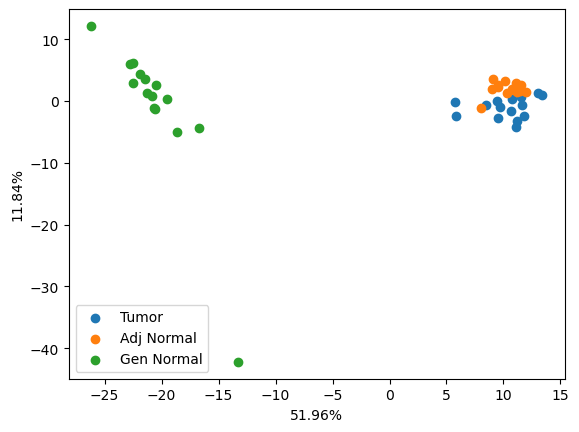

In [88]:
config_opt = yaml.safe_load(open('opt.yaml', 'r'))
i = 2
idx_filtered_d = np.r_[0:len(idx_camp_disease[i][0])]
idx_filtered_n = np.r_[0:len(idx_camp_normal[i][0])]

# Get the original cohort indices
normal_camp = np_normal_log[idx_camp_normal[i][0],:]
normal_camp_lbls = np_normal_lbls[idx_camp_normal[i][0]]

tumor_camp = np_tumor_log[idx_camp_disease[i][0],:]
tumor_camp_lbls = np_tumor_lbls[idx_camp_disease[i][0]]


gen = np.random.default_rng(0)
rn_idx_grp_01 = gen.choice(idx_filtered_n,size=n_samples, replace=False)
rn_other_idx = np.array(list(set(idx_filtered_n) - set(rn_idx_grp_01)))

# Get indices from disease group
rn_idx_grp_02 = gen.choice(idx_filtered_d,size=n_samples, replace=False)
rn_other_idx = np.array(list(set(idx_filtered_d) - set(rn_idx_grp_02)))


## ADJ NORMAL
rn_grp_01 = normal_camp[rn_idx_grp_01]
rn_grp_01_lbls = normal_camp_lbls[rn_idx_grp_01]


## TUMOR
rn_grp_02 = tumor_camp[rn_idx_grp_02]
rn_grp_02_lbls = tumor_camp_lbls[rn_idx_grp_02]

# [GN] Initialize the dataset
tumor_ds = MetaboliteDataset(
    np_mat=rn_grp_02,
    cohort_labels=rn_grp_02_lbls
)
## GEN NORMAL
rep_normal, dec_normal = dgd_final.get_representations(tumor_ds, config_opt)
gn_grp = dec_normal.detach().numpy()


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(np.vstack((rn_grp_02, rn_grp_01, gn_grp)))

plt.scatter(pca_fit[0:15,0], pca_fit[0:15,1], c='C0', label='Tumor')
plt.scatter(pca_fit[15:30,0], pca_fit[15:30,1], c='C1', label='Adj Normal')
plt.scatter(pca_fit[30:45,0], pca_fit[30:45,1], c='C2', label='Gen Normal')
plt.xlabel(f'{(pca.explained_variance_ratio_[0] * 100):.2f}%')
plt.ylabel(f'{(pca.explained_variance_ratio_[1] * 100):.2f}%')
plt.legend()

PCA to Make Sure

???

In [ ]:
coad_test = cohorts_normal['COAD']['met_list']
coad_cm_fname = os.listdir('cancer_metabolites/')
coad_cm_list = []
for c in coad_cm_fname:
    df = pd.read_csv('cancer_metabolites/' + c)
    coad_cm_list += df['Standard Name'].to_list()

    # Metabolite names
    temp_mn = df['Metabolite Name'].to_list()
    for t in temp_mn:
        coad_cm_list.append(t)


detectable_metabolites = []
for c in coad_cm_list:
    if c in coad_test:
        detectable_metabolites.append(c)
    elif c.lower() in coad_test:
        detectable_metabolites.append(c.lower())

In [ ]:
detectable_metabolites = []
for c in coad_cm_list:
    if c in coad_test:
        detectable_metabolites.append(c)
    elif c.lower() in coad_test:
        detectable_metabolites.append(c.lower())

In [ ]:
np.count_nonzero(np.isin(dam_list, detectable_metabolites))

In [ ]:
idx_camp_coad_disease = np.r_[180:217]
idx_filtered_disease = np.r_[0:len(idx_camp_coad_disease)]

disease_camp_coad = np_tumor_log[idx_camp_coad_disease,:]
disease_camp_coad_lbls = np_tumor_lbls[idx_camp_coad_disease]

disease_ds = MetaboliteDataset(
    np_mat=disease_camp_coad,
    cohort_labels=disease_camp_coad_lbls
)

rep_disease, dec_disease = dgd_final.get_representations(
                                        disease_ds,
                                        config_opt
                                    )

In [ ]:
gn_grp_disease = dec_normal.detach().numpy()
df_rdgn = daa.get_daa_mwu_metrics(disease_camp_coad, gn_grp_disease, metabolite_list)
df_rdgn = df_rdgn.iloc[idx_coad_metabolite_list]

In [ ]:
df_rdrn = daa.get_daa_mwu_metrics(disease_camp_coad, normal_camp_coad, metabolite_list)
df_rdrn = df_rdrn.iloc[idx_coad_metabolite_list]

In [ ]:
# Get DAM counts per threshold across all samples
dgd_dam_counts = []
mwu_dam_counts = []


for t in threshold:
    mwu_dam_counts.append(len(df_rdrn.loc[(df_rdrn['p_value'] < t) & (df_rdrn['log2_fold_change'] > 1)]))
    dgd_dam_counts.append(len(df_rdgn.loc[(df_rdgn['p_value'] < t) & (df_rdgn['log2_fold_change'] > 1)]))

In [ ]:
sensitivity_results = {
    'dgd_dam_counts': dgd_dam_counts,
    'mwu_dam_counts': mwu_dam_counts
}

f = open('outputs/sensitivity_results.pkl', 'wb')
pickle.dump(sensitivity_results, f)
f.close()

???

In [ ]:
# # COAD Samples Only
# normal_coad = np_normal_log[118:157,:]
# tumor_coad = np_tumor_log[180:217,:]

# p_val = mannwhitneyu(tumor_coad,normal_coad, alternative='two-sided').pvalue
# q_val = false_discovery_control(p_val, method='bh')

In [ ]:
# # Use decoder output and decoder's std for norm
# idx_disease_camp_coad = 200
# loc = dec_out_final[idx_disease_camp_coad,:]
# scale = dgd_final.dec.normal_layer.std.detach().flatten().numpy()

# # Get first sample
# tumor_coad = np_tumor_log[idx_disease_camp_coad]
# gen_norm_coad = np.copy(loc)

# # Use observed abundance
# lhs = norm.cdf(tumor_coad, loc=loc, scale=scale)
# rhs = 1 - lhs

# p_vals = 2 * np.minimum(lhs, rhs)
# q_vals = false_discovery_control(p_vals, method='bh')

# log2_fold_changes = (tumor_coad + 1e-6) / (gen_norm_coad + 1e-6)

# results_df = \
#     pd.DataFrame({
#         'p_value': p_vals,
#         'q_value': q_vals,
#         'log2_fold_changes': log2_fold_changes
#     }, index=metabolite_list)

# results_df.loc[(results_df['q_value']<0.1) & (results_df['log2_fold_changes']>1)]

In [ ]:
    # dea_count_t = []
    # for i in range(0,n_samples):
    #     dea_count_t.append(len(q_vals[i][q_vals[i]<t]))

In [ ]:
# # Setup the Normal Distributions
# loc = dec_normal.detach().numpy()
# scale = dgd_final.dec.normal_layer.std.detach().flatten().numpy()

# # Get the LHS and RHS
# lhs = norm.cdf(normal_camp_coad, loc=loc, scale=scale)
# rhs = 1 - lhs

# # Get the p-values and q-values per sample per metabolite
# p_vals = 2 * np.minimum(lhs, rhs)
# q_vals = false_discovery_control(p_vals, method='bh')

In [ ]:
# p_vals_mwu = mannwhitneyu(np_normal_log[random_camp_coad_idx], np_normal_log[others_camp_coad_idx], alternative='two-sided').pvalue
# q_vals = false_discovery_control(ps=p_vals_mwu, method='bh')

In [ ]:
# # Get DAM counts per threshold across all samples
# dgd_dam_counts = []
# mwu_dam_counts = []


# for t in threshold:
#     mwu_dam_counts.append(len(df_rnrn.loc[(df_rnrn['p_value'] < t) & (df_rnrn['log2_fold_change'] > 1)]))
#     dgd_dam_counts.append(len(df_rngn.loc[(df_rngn['p_value'] < t) & (df_rngn['log2_fold_change'] > 1)]))

# specificity_results = {
#     'dgd_dam_counts': dgd_dam_counts,
#     'mwu_dam_counts': mwu_dam_counts
# }

# f = open('outputs/specificity_results.pkl', 'wb')
# pickle.dump(specificity_results, f)
# f.close()